## Optimal transport in neuroimaging

<h4 align="right"> Author: Hicham Janati <hicham.janati@inria.fr></h4>
<h5 align="right"> July 2019 </h5>

This example shows how to compute Optimal transport barycenters of brain activations on the cortical surface.

In order to run this notebook, you need to install the following packages: [MNE](http://martinos.org/mne), [nilearn](http://nilearn.github.io), [POT](https://pot.readthedocs.io), [numba](https://numba.pydata.org/). 

To do so, run in a Terminal:

`pip install mne nilearn pot numba`


In [1]:
import os

import numpy as np
from numba import jit

from ot.unbalanced import barycenter_unbalanced

import mne
import nilearn
from nilearn import plotting
from matplotlib import pyplot as plt


data_path = mne.datasets.sample.data_path()
subjects_dir = os.path.join(data_path, "subjects")

resolution = 4
spacing = 'ico%d' % resolution

Functions to compute the ground metric -- geodesic over the triangulated mesh of the brain surface.

In [2]:
@jit(nogil=True, cache=True, nopython=True)
def floyd_warshall(dist):
    npoints = dist.shape[0]
    for k in range(npoints):
        for i in range(npoints):
            for j in range(npoints):
                # If i and j are different nodes and if
                # the paths between i and k and between
                # k and j exist, do
                # d_ikj = min(dist[i, k] + dist[k, j], dist[i, j])
                d_ikj = dist[i, k] + dist[k, j]
                if ((d_ikj != 0.) and (i != j)):
                    # See if you can't get a shorter path
                    # between i and j by interspacing
                    # k somewhere along the current
                    # path
                    if ((d_ikj < dist[i, j]) or (dist[i, j] == 0)):
                        dist[i, j] = d_ikj
    return dist


def mesh_all_distances(points, tris, verts=None):
    """Compute all pairwise distances on the mesh based on edges lengths
    using Floyd-Warshall algorithm
    """
    A = mne.surface.mesh_dist(tris, points)
    if verts is not None:
        A = A[verts][:, verts]
    A = A.toarray()
    A[A == 0.] = 1e6
    A.flat[::len(A) + 1] = 0.
    print('Running Floyd-Warshall algorithm ...')
    A = floyd_warshall(A)
    return A


def get_surface(spacing=spacing, subjects_dir=subjects_dir):
    print('Computing source space ...')
    src = mne.setup_source_space(subject="fsaverage",
                                 spacing=spacing,
                                 subjects_dir=subjects_dir,
                                 add_dist=False,
                                 verbose=False)
    tris = src[0]["use_tris"]
    vertno = src[0]["vertno"]
    points = src[0]["rr"][vertno]
    return points, tris


surf = get_surface()
D = mesh_all_distances(*surf)

n_features = len(D)

print(f"shape of the ground metric: {D.shape}")
print(f"Largest geodesic distance on the mesh: {100 * D.max():.2f} cm")


Computing source space ...
Running Floyd-Warshall algorithm ...
shape of the ground metric: (2562, 2562)
Largest geodesic distance on the mesh: 23.63 cm


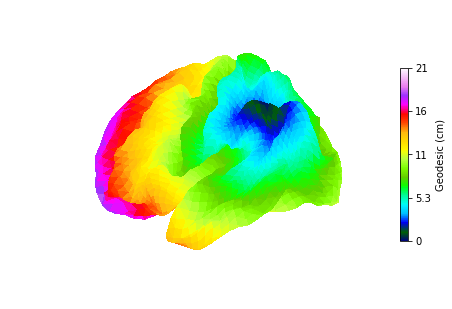

In [3]:
# We plot the ground metric with respect to the vertex 5, located in the black region
view = plotting.plot_surf_roi(surf, 100 * D[5], colorbar=True)
ax, colorbar_ax = view.get_axes()
_ = colorbar_ax.set_ylabel("Geodesic (cm)")

#### Interactive plotting with nilearn


In [4]:
# We change the units of the coordinates for a larger initial view
pts, tris = surf
view = plotting.view_surf((10 * pts, tris), 100 * D[5])
view.resize(1200, 500)

### OT in neuroimaging

In [5]:
seed = 42
rng = np.random.RandomState(seed)


label_name = 'lh.BA45'
fname_label = os.path.join(subjects_dir,
                           'fsaverage/label/%s.label' % label_name)
label = mne.read_label(fname_label, subject="fsaverage")
label = label.morph(subject_to="fsaverage", grade=resolution,
                    subjects_dir=subjects_dir)

n_subjects = 6
activation_size = 3
activations = np.zeros((n_features, n_subjects))
for i in range(n_subjects):
    picks = rng.choice(label.vertices, activation_size)
    activations[picks, i] = rng.rand(activation_size) + 3

bg_map = os.path.join(subjects_dir, "fsaverage/surf/lh.sulc")

# taking only the first vertices corresponding to the low resolution
# surface
bg_map = nilearn.surface.load_surf_data(bg_map)[:n_features]


Visualize the individual activations:

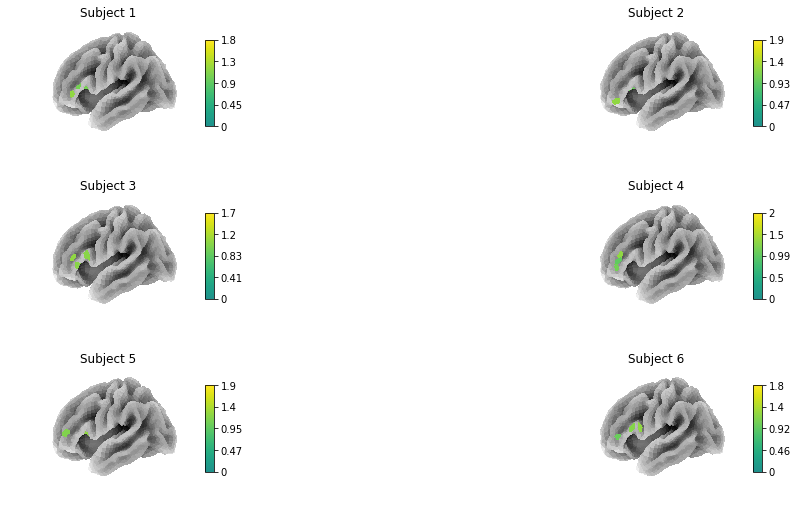

In [6]:
f, axes = plt.subplots(n_subjects // 2, 2, subplot_kw={'projection': '3d'}, figsize=(18, 9))
axes = axes.ravel()
for i in range(n_subjects):
    view = plotting.plot_surf_stat_map(surf, activations[:, i], colorbar=True,
                                       alpha=1., threshold=0.01, cmap="viridis",
                                       bg_map=bg_map, axes=axes[i],
                                       vmax=activations[:, i].max() / 2)
    
    axes[i].set_title("Subject %d" % (i + 1))

### Euclidean averaging:

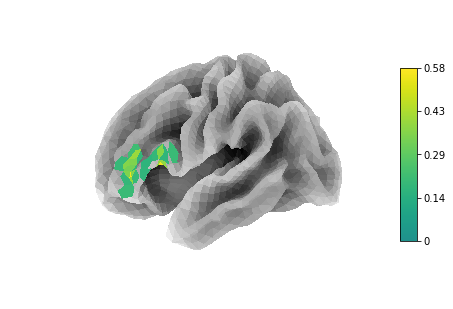

In [7]:
euclidean_mean = abs(activations).mean(axis=1)
view = plotting.plot_surf_stat_map(surf, euclidean_mean, colorbar=True, cmap="viridis",
                                   alpha=1., threshold=0.01,
                                   bg_map=bg_map, vmax=euclidean_mean.max() / 2)

### Optimal transport averaging:
The Wasserstein distance only applies to normalized histograms (probability measures). To compute barycenters of unnormalized signals, one can allow the loss and creation of mass by replace the marginal constraints by inequalities [1]. In the example below we use the more elegant alternative of Unbalanced Optimal transport [2] which can be easily applied on neuroimaging data as in [3] where Unbalanced OT was leveraged to model spatial consistency across subjects.

In [8]:
M = D / np.median(D)  # this normalization by the median works well in practice
epsilon = 1. / n_features  # Entropy regularization
alpha = 10.  # Unbalanced regularization
barycenter = barycenter_unbalanced(abs(activations) + 1e-10, M, epsilon, alpha)

/Users/hichamjanati/miniconda3/lib/python3.6/site-packages/ot/unbalanced.py:501: RuntimeWarning: overflow encountered in square
  err = np.sum((u - uprev) ** 2) / np.sum((u) ** 2) + \
/Users/hichamjanati/miniconda3/lib/python3.6/site-packages/ot/unbalanced.py:501: RuntimeWarning: invalid value encountered in double_scalars
  err = np.sum((u - uprev) ** 2) / np.sum((u) ** 2) + \


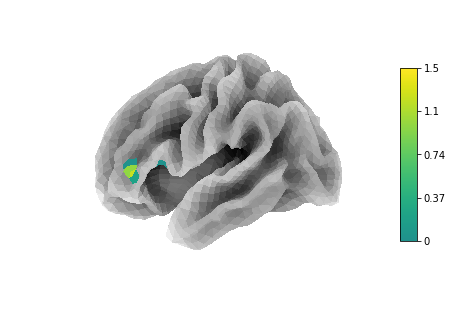

In [9]:
view = plotting.plot_surf_stat_map(surf, barycenter, colorbar=True, cmap="viridis",
                                   alpha=1., threshold=0.01,
                                   bg_map=bg_map, vmax=barycenter.max() / 2)

The Wasserstein barycenter is more accurate and does not suffer from undesirable smoothing.

#### references

[1] Alexandre Gramfort, Gabriel Peyré, Marco Cuturi. <a href=https://hal.archives-ouvertes.fr/hal-01135198/document> Fast Optimal Transport Averaging of Neuroimaging Data.</a> Information Processing in Medical Imaging (IPMI), Jun 2015, Isle of Skye, United Kingdom.
ffhal-01135198f

[2] Lénaic Chizat. and Peyré, G. and Schmitzer, B. and Vialard, F-X. <a href=https://arxiv.org/abs/1607.05816 >Scaling Algorithms for Unbalanced Transport Problems. </a> arXiv Preprint 1607.05816 2017.

[3] Hicham Janati and Marco Cuturi and Alexandre Gramfort. <a href=http://proceedings.mlr.press/v89/janati19a.html> Wasserstein regularization for sparse multi-task regression </a>, AISTATS 2019. 